In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import seaborn.apionly as snsa
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import warnings
import pyproj
import folium

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

pd.set_option('display.max_columns', None)

# Descriptive statistics

In [3]:
# Read merged LL84 - PLUTO data
df = pd.read_csv(r'..\Data\LL84_PLUTO.csv')
del df['Unnamed: 0']

# Fix the name of columns reported in unicode
cols = df.columns.str.replace('\xb2', '_2')
df.columns = cols

# Standardize reported entries
df.replace(to_replace='Not Available', value=np.nan, inplace=True)
df.replace(to_replace='NA', value=np.nan, inplace=True)
df.replace(to_replace='\t', value=' ', inplace=True)
df.replace(to_replace=u'\u2022', value=' ', inplace=True)

# Convert values to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Do some initial cleaning in misreported values
df = df[(df['Property GFA - Self-Reported (ft_2)'] > 50000)]
df = df[(df['Year Built'] > 0)]
df = df[(df['Weather Normalized Source EUI (kBtu/ft_2)'] > 0)]

# Calculate log energy intensity for statistical cleaning
df['eui'] = df['Weather Normalized Source EUI (kBtu/ft_2)']
df['log_eui'] = np.log(df['eui'])

# Bin the data for further analysis
year_label = ['Pre 1930','1930-1950', '1950-1970', '1970-1990','1990-2015']
size_label = ['<100,000','100,000-300,000', '300,000-500,000', '500,000-1,000,000','>1,000,000']
height_label = ['low rise', 'mid rise', 'high rise']

df['ageBins'] = pd.cut(df['YearBuilt'], bins=[0, 1930, 1950, 1970, 1990, 2015],labels=year_label)
df['sizeBins'] = pd.cut(df['Property GFA - Self-Reported (ft_2)'], bins=[0, 100000, 300000, 500000, 1000000, 100000000],
                        labels=size_label)
df['heightBins'] = pd.cut(df['NumFloors'], bins=[0, 7, 19, 200],labels=height_label)

# Get each individual category
of = df[df['Primary Property Type - Self Selected']=='Office']
mf = df[df['Primary Property Type - Self Selected']=='Multifamily Housing']
hotel = df[df['Primary Property Type - Self Selected']=='Hotel']

def clean_eui(df):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    df = df[(df.log_eui<np.mean(df.log_eui)+2*np.std(df.log_eui))&(df.log_eui>np.mean(df.log_eui)-2*np.std(df.log_eui))]
    return df

print 'Total number of properties by type (prior to removing outliers)'
print '---------------------------------------------------------------'
print 'Office buildings, n =', of.shape[0]
print 'Multifamily housing buildings, n =', mf.shape[0]
print 'Hotel buildings, n =', hotel.shape[0]

# Remove outliers based on 2 standard deviation rule
of = clean_eui(of)
mf = clean_eui(mf)
hotel = clean_eui(hotel)

# Removing additional outliers that cleaning process failed to capture and skew the distribution
hotel = hotel[hotel.eui<7000]

print 'Total number of properties by type (after removing outliers)'
print '---------------------------------------------------------------'
print 'Office buildings, n =', of.shape[0]
print 'Multifamily housing buildings, n =', mf.shape[0]
print 'Hotel buildings, n =', hotel.shape[0]

C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (12,74,263,264,265,268,269,284) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\sp4356\AppData\Local\Continuum\Anaconda2\lib\site-packages\pandas\core\missing.py:38: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  mask = arr == x


Total number of properties by type (prior to removing outliers)
---------------------------------------------------------------
Office buildings, n = 1341
Multifamily housing buildings, n = 8239
Hotel buildings, n = 261
Total number of properties by type (after removing outliers)
---------------------------------------------------------------
Office buildings, n = 1300
Multifamily housing buildings, n = 8056
Hotel buildings, n = 254


In [8]:
# Output office buildings csv file for future usage
of.to_csv('..\Output\LL84_office.csv')

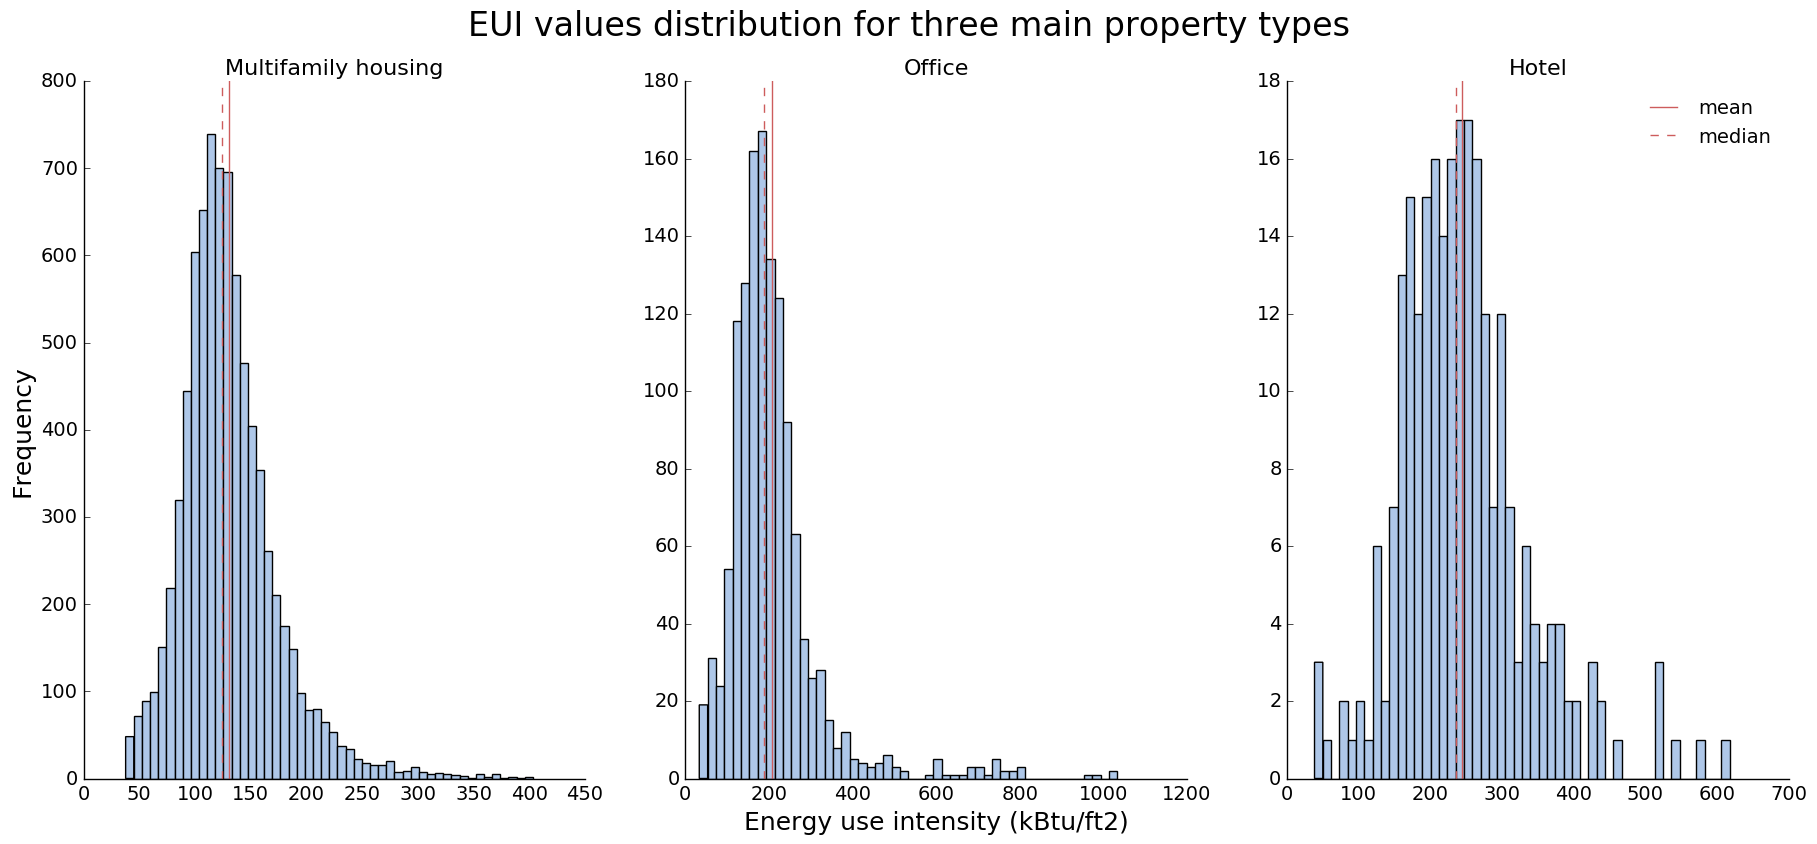

In [4]:
# Plot histograms

plt.figure(figsize=(22,9))
plt.suptitle('EUI values distribution for three main property types',size=24)
plt.subplot(131)
plt.hist(mf.eui,bins=50,color=tableau20[1])
plt.ylabel('Frequency')
plt.axvline(x=mf.eui.mean(),color='indianred')
plt.axvline(x=mf.eui.median(),color='indianred',linestyle='--')
plt.title('Multifamily housing',size=16)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(132)
plt.hist(of.eui,bins=50,color=tableau20[1])
plt.axvline(x=of.eui.mean(),color='indianred')
plt.axvline(x=of.eui.median(),color='indianred',linestyle='--')
plt.xlabel('Energy use intensity (kBtu/ft2)')
plt.title('Office',size=16)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(133)
plt.hist(hotel.eui,bins=50,color=tableau20[1])
plt.axvline(x=hotel.eui.mean(),color='indianred', label='mean')
plt.axvline(x=hotel.eui.median(),color='indianred',linestyle='--',label='median')
plt.title('Hotel',size=16)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.legend()
#plt.savefig('..\Figures\eui_hist_3types.png')
plt.show()

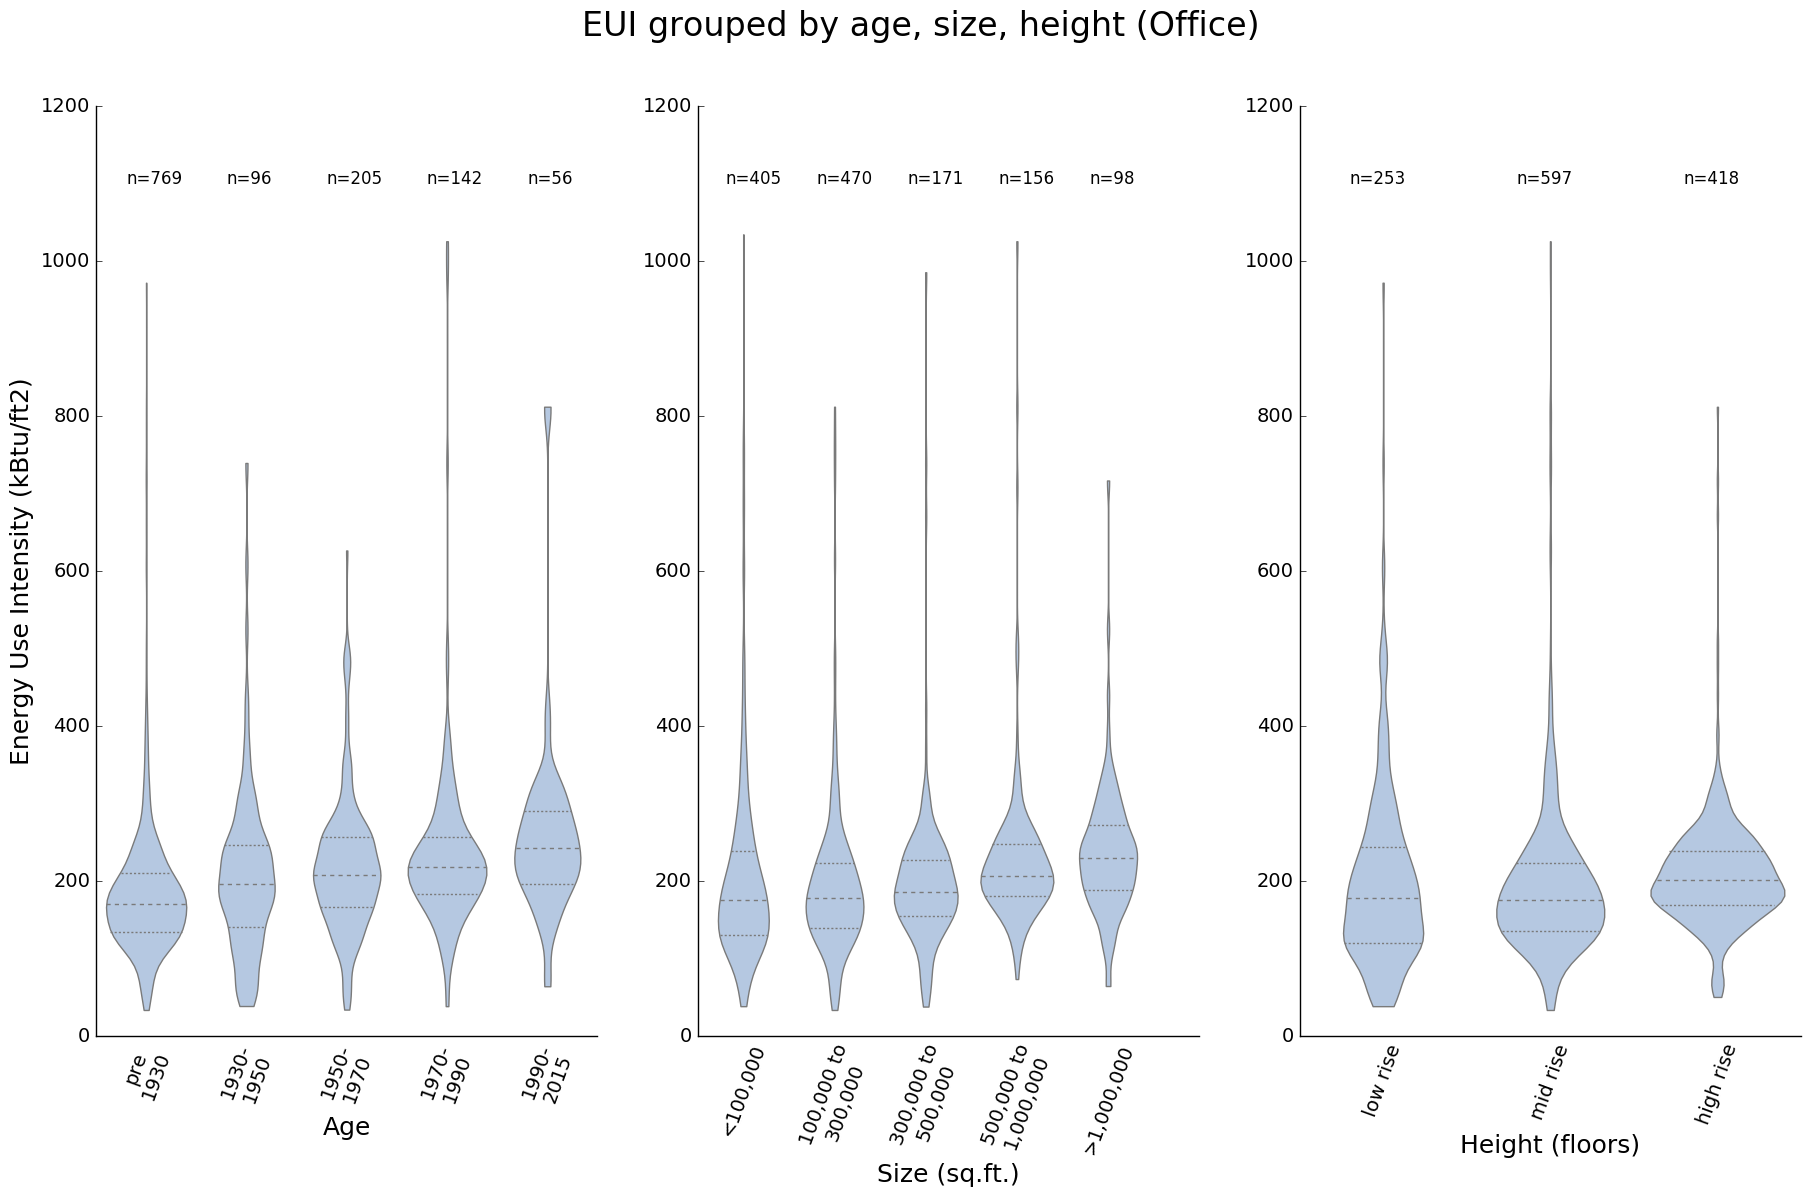

In [5]:
# Plot violin plots

plt.figure(figsize=(22,12))
plt.suptitle('EUI grouped by age, size, height (Office)',size=24)
plt.subplot(131)
snsa.violinplot(x='ageBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=of, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('Energy Use Intensity (kBtu/ft2)')
plt.xlabel('Age')
plt.xticks(range(5), ['pre\n1930','1930-\n1950','1950-\n1970','1970-\n1990','1990-\n2015'],rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 1100, 'n=%d'%of.groupby('ageBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 1100, 'n=%d'%of.groupby('ageBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 1100, 'n=%d'%of.groupby('ageBins')['Property Id'].count().values[2],fontsize=12)
plt.text(2.8, 1100, 'n=%d'%of.groupby('ageBins')['Property Id'].count().values[3],fontsize=12)
plt.text(3.8, 1100, 'n=%d'%of.groupby('ageBins')['Property Id'].count().values[4],fontsize=12)
plt.subplot(132)
snsa.violinplot(x='sizeBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=of, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('')
plt.xlabel('Size (sq.ft.)')
plt.xticks(range(6),['<100,000','100,000 to\n300,000', '300,000 to\n500,000', '500,000 to\n1,000,000','>1,000,000'],
           rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 1100, 'n=%d'%of.groupby('sizeBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 1100, 'n=%d'%of.groupby('sizeBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 1100, 'n=%d'%of.groupby('sizeBins')['Property Id'].count().values[2],fontsize=12)
plt.text(2.8, 1100, 'n=%d'%of.groupby('sizeBins')['Property Id'].count().values[3],fontsize=12)
plt.text(3.8, 1100, 'n=%d'%of.groupby('sizeBins')['Property Id'].count().values[4],fontsize=12)
plt.subplot(133)
snsa.violinplot(x='heightBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=of, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('')
plt.xlabel('Height (floors)')
plt.xticks(rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 1100, 'n=%d'%of.groupby('heightBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 1100, 'n=%d'%of.groupby('heightBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 1100, 'n=%d'%of.groupby('heightBins')['Property Id'].count().values[2],fontsize=12)
#plt.savefig(r'..\Figures\violin_office.png')
plt.show()

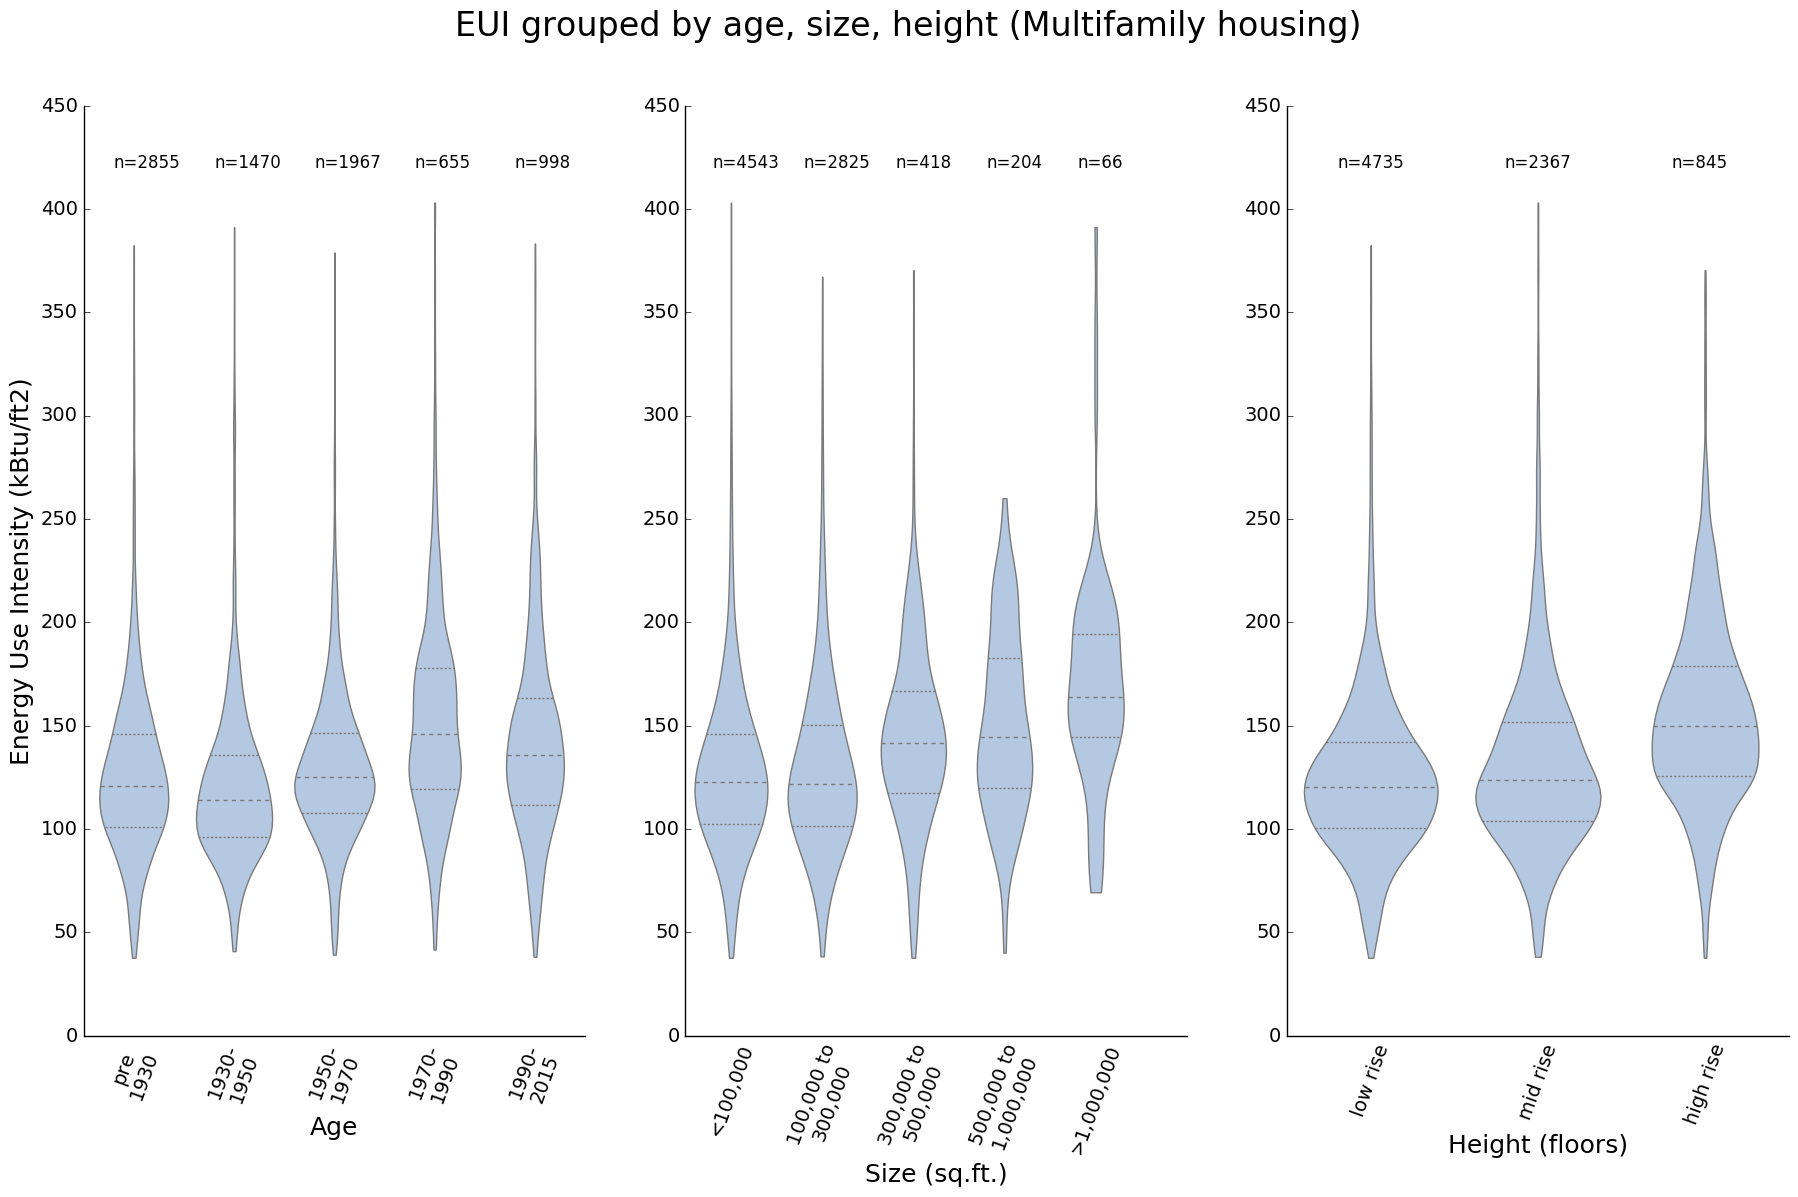

In [9]:
plt.figure(figsize=(22,12))
plt.suptitle('EUI grouped by age, size, height (Multifamily housing)',size=24)
plt.subplot(131)
snsa.violinplot(x='ageBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=mf, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('Energy Use Intensity (kBtu/ft2)')
plt.xlabel('Age')
plt.xticks(range(5), ['pre\n1930','1930-\n1950','1950-\n1970','1970-\n1990','1990-\n2015'],rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 420, 'n=%d'%mf.groupby('ageBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 420, 'n=%d'%mf.groupby('ageBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 420, 'n=%d'%mf.groupby('ageBins')['Property Id'].count().values[2],fontsize=12)
plt.text(2.8, 420, 'n=%d'%mf.groupby('ageBins')['Property Id'].count().values[3],fontsize=12)
plt.text(3.8, 420, 'n=%d'%mf.groupby('ageBins')['Property Id'].count().values[4],fontsize=12)
plt.subplot(132)
snsa.violinplot(x='sizeBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=mf, 
                     bw=0.3, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('')
plt.xlabel('Size (sq.ft.)')
plt.xticks(range(6),['<100,000','100,000 to\n300,000', '300,000 to\n500,000', '500,000 to\n1,000,000','>1,000,000'],
           rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 420, 'n=%d'%mf.groupby('sizeBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 420, 'n=%d'%mf.groupby('sizeBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 420, 'n=%d'%mf.groupby('sizeBins')['Property Id'].count().values[2],fontsize=12)
plt.text(2.8, 420, 'n=%d'%mf.groupby('sizeBins')['Property Id'].count().values[3],fontsize=12)
plt.text(3.8, 420, 'n=%d'%mf.groupby('sizeBins')['Property Id'].count().values[4],fontsize=12)
plt.subplot(133)
snsa.violinplot(x='heightBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=mf, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('')
plt.xlabel('Height (floors)')
plt.xticks(rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 420, 'n=%d'%mf.groupby('heightBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 420, 'n=%d'%mf.groupby('heightBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 420, 'n=%d'%mf.groupby('heightBins')['Property Id'].count().values[2],fontsize=12)
#plt.savefig(r'..\Figures\violin_multifamily.png')
plt.show()

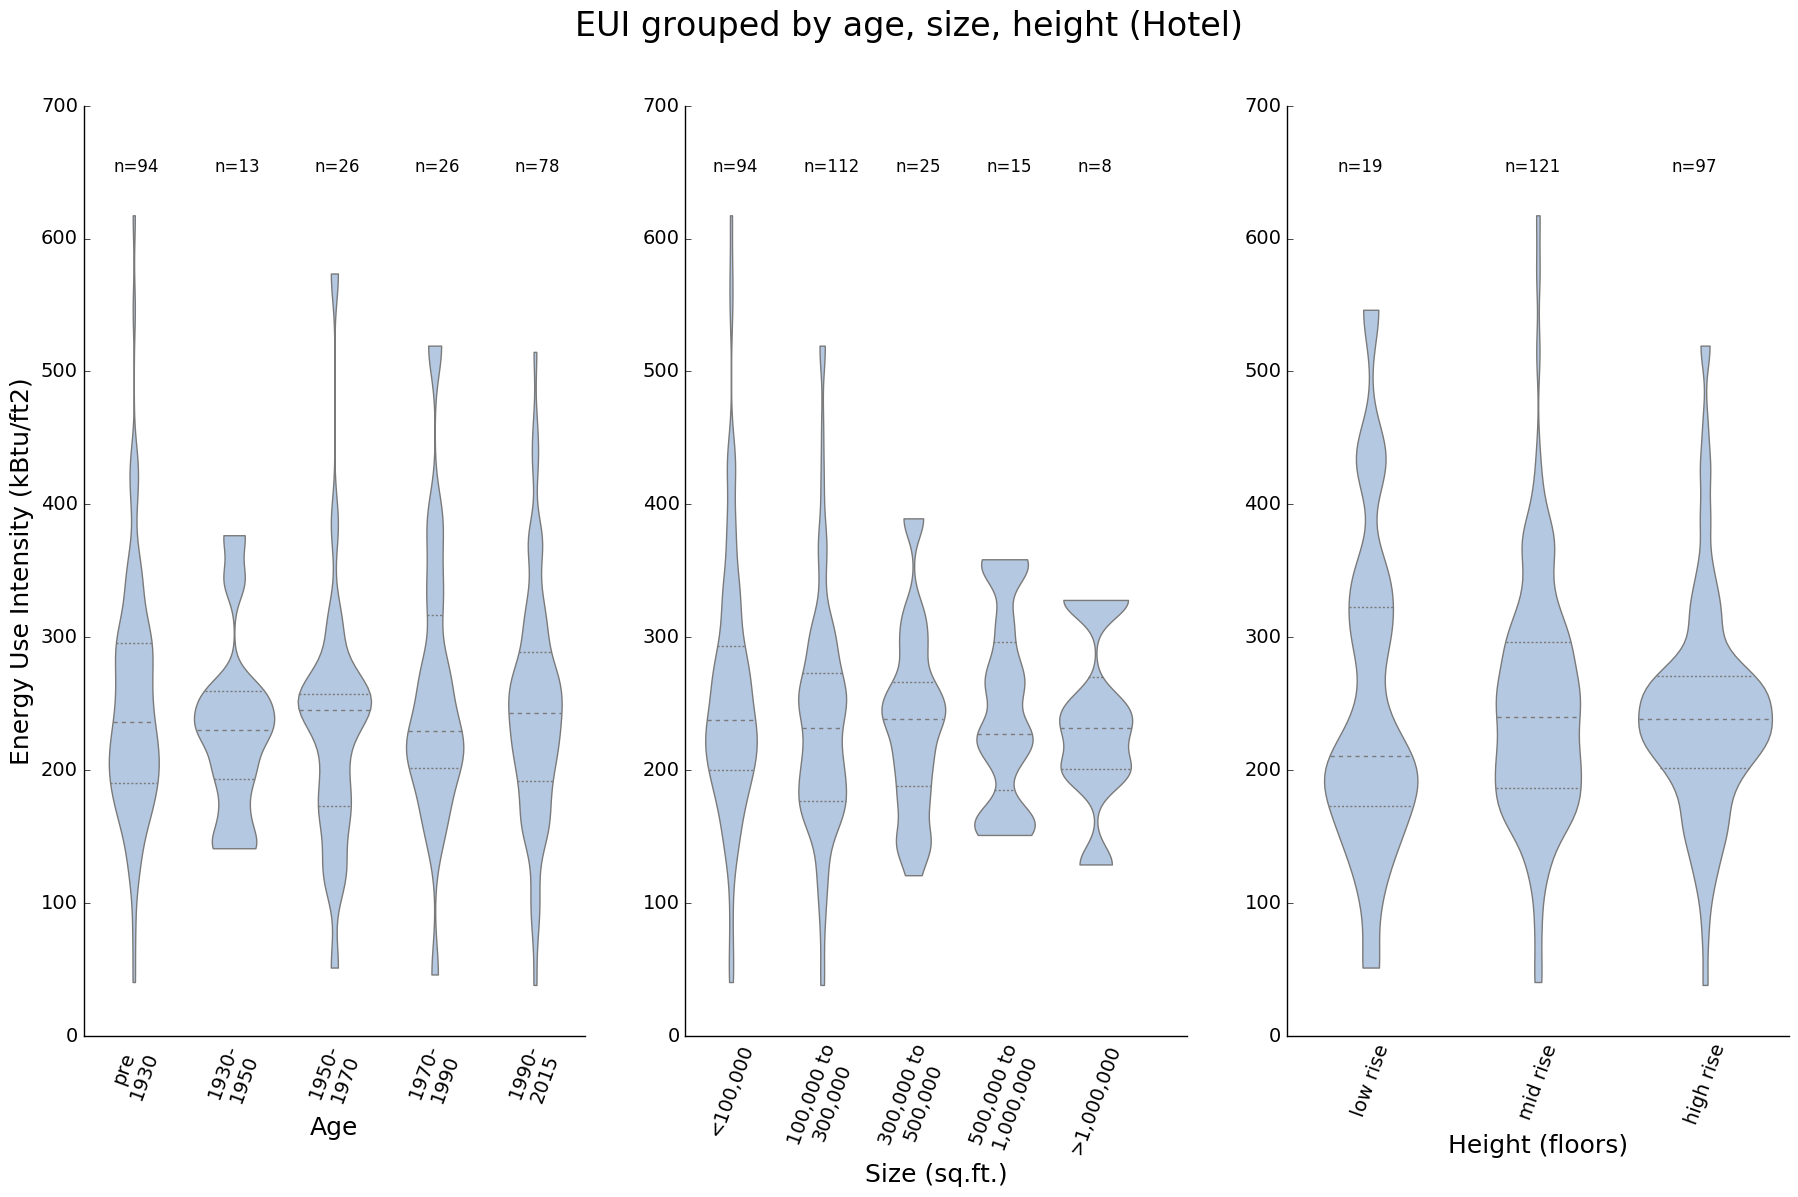

In [10]:
plt.figure(figsize=(22,12))
plt.suptitle('EUI grouped by age, size, height (Hotel)',size=24)
plt.subplot(131)
snsa.violinplot(x='ageBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=hotel, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('Energy Use Intensity (kBtu/ft2)')
plt.xlabel('Age')
plt.xticks(range(5), ['pre\n1930','1930-\n1950','1950-\n1970','1970-\n1990','1990-\n2015'],rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 650, 'n=%d'%hotel.groupby('ageBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 650, 'n=%d'%hotel.groupby('ageBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 650, 'n=%d'%hotel.groupby('ageBins')['Property Id'].count().values[2],fontsize=12)
plt.text(2.8, 650, 'n=%d'%hotel.groupby('ageBins')['Property Id'].count().values[3],fontsize=12)
plt.text(3.8, 650, 'n=%d'%hotel.groupby('ageBins')['Property Id'].count().values[4],fontsize=12)
plt.subplot(132)
snsa.violinplot(x='sizeBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=hotel, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('')
plt.xlabel('Size (sq.ft.)')
plt.xticks(range(6),['<100,000','100,000 to\n300,000', '300,000 to\n500,000','500,000 to\n1,000,000','>1,000,000'],
           rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 650, 'n=%d'%hotel.groupby('sizeBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 650, 'n=%d'%hotel.groupby('sizeBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 650, 'n=%d'%hotel.groupby('sizeBins')['Property Id'].count().values[2],fontsize=12)
plt.text(2.8, 650, 'n=%d'%hotel.groupby('sizeBins')['Property Id'].count().values[3],fontsize=12)
plt.text(3.8, 650, 'n=%d'%hotel.groupby('sizeBins')['Property Id'].count().values[4],fontsize=12)
plt.ylim(0,700)
plt.subplot(133)
snsa.violinplot(x='heightBins', 
                     y='Weather Normalized Source EUI (kBtu/ft_2)', 
                     data=hotel, 
                     bw=0.2, 
                     inner="quartile", 
                     cut=0, 
                     split=True, 
                     color=tableau20[1])
plt.ylabel('')
plt.xlabel('Height (floors)')
plt.xticks(rotation=70)
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.text(-0.2, 650, 'n=%d'%hotel.groupby('heightBins')['Property Id'].count().values[0],fontsize=12)
plt.text(0.8, 650, 'n=%d'%hotel.groupby('heightBins')['Property Id'].count().values[1],fontsize=12)
plt.text(1.8, 650, 'n=%d'%hotel.groupby('heightBins')['Property Id'].count().values[2],fontsize=12)
#plt.savefig(r'..\Figures\violin_hotel.png')
plt.show()

In [11]:
def plot_agg_energy(x, grouping):
    """Aggregates the energy mix for each building type and 
    each grouping category (age, size, height).
    
    Outputs the ratios of each energy source."""
    
    fuelSummary = x.groupby(grouping).agg({'Electricity Use - Grid Purchase (kBtu)':np.sum,
                               'District Steam Use (kBtu)':np.sum,
                               'Natural Gas Use (kBtu)':np.sum,
                               'Fuel Oil #2 Use (kBtu)':np.sum,
                               'Fuel Oil #4 Use (kBtu)':np.sum,
                               'Fuel Oil #5 & 6 Use (kBtu)':np.sum})
    
    ratios = 100*fuelSummary.apply(lambda y: y/fuelSummary.sum(axis=1))
    
    energy_lab = ['Electricity (kBtu)', 'District Steam (kBtu)','Natural Gas (kBtu)',
                'Fuel Oil #2 (kBtu)','Fuel Oil #4 (kBtu)','Fuel Oil #5 & 6 (kBtu)']
    ratios.columns = energy_lab
    ratios = ratios.reindex_axis(energy_lab[::-1], axis=1)
    return ratios

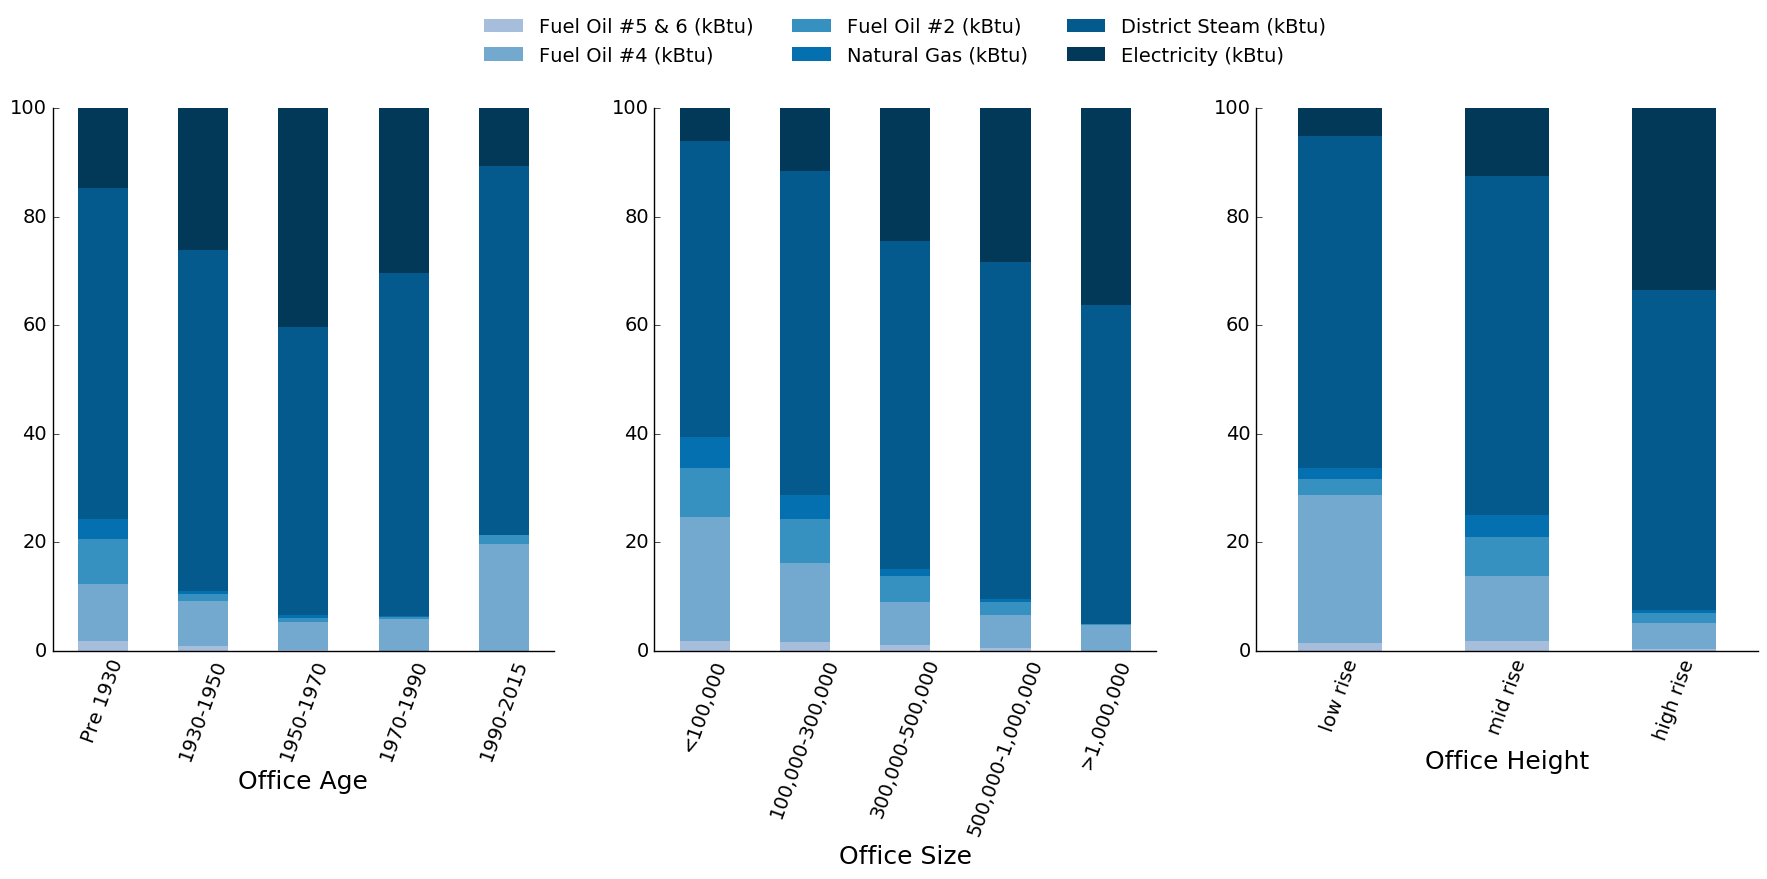

In [12]:
# Set color pallette
puBu = ["#a6bddb", "#74a9cf", "#3690c0", "#0570b0", "#045a8d", "#023858"]

# Plot office energy mix
fig = plt.figure(figsize=(22, 7))
sub1 = fig.add_subplot(131)
plot_agg_energy(of, 'ageBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub1,ylim=[0,100],legend=False)
sub1.set_xlabel('Office Age')
sub1.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub1.set_xticklabels(sub1.xaxis.get_majorticklabels(),rotation=70)
sub2 = fig.add_subplot(132)
plot_agg_energy(of, 'sizeBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub2,ylim=[0,100],legend=True)
sub2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=False)
sub2.set_xlabel('Office Size')
sub2.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub2.set_xticklabels(sub2.xaxis.get_majorticklabels(),rotation=70)
sub3 = fig.add_subplot(133)
plot_agg_energy(of, 'heightBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub3,ylim=[0,100],legend=False)
sub3.set_xlabel('Office Height')
sub3.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub3.set_xticklabels(sub3.xaxis.get_majorticklabels(),rotation=70)
#plt.savefig('..\Figures\energyMixOffice.png')
plt.show()

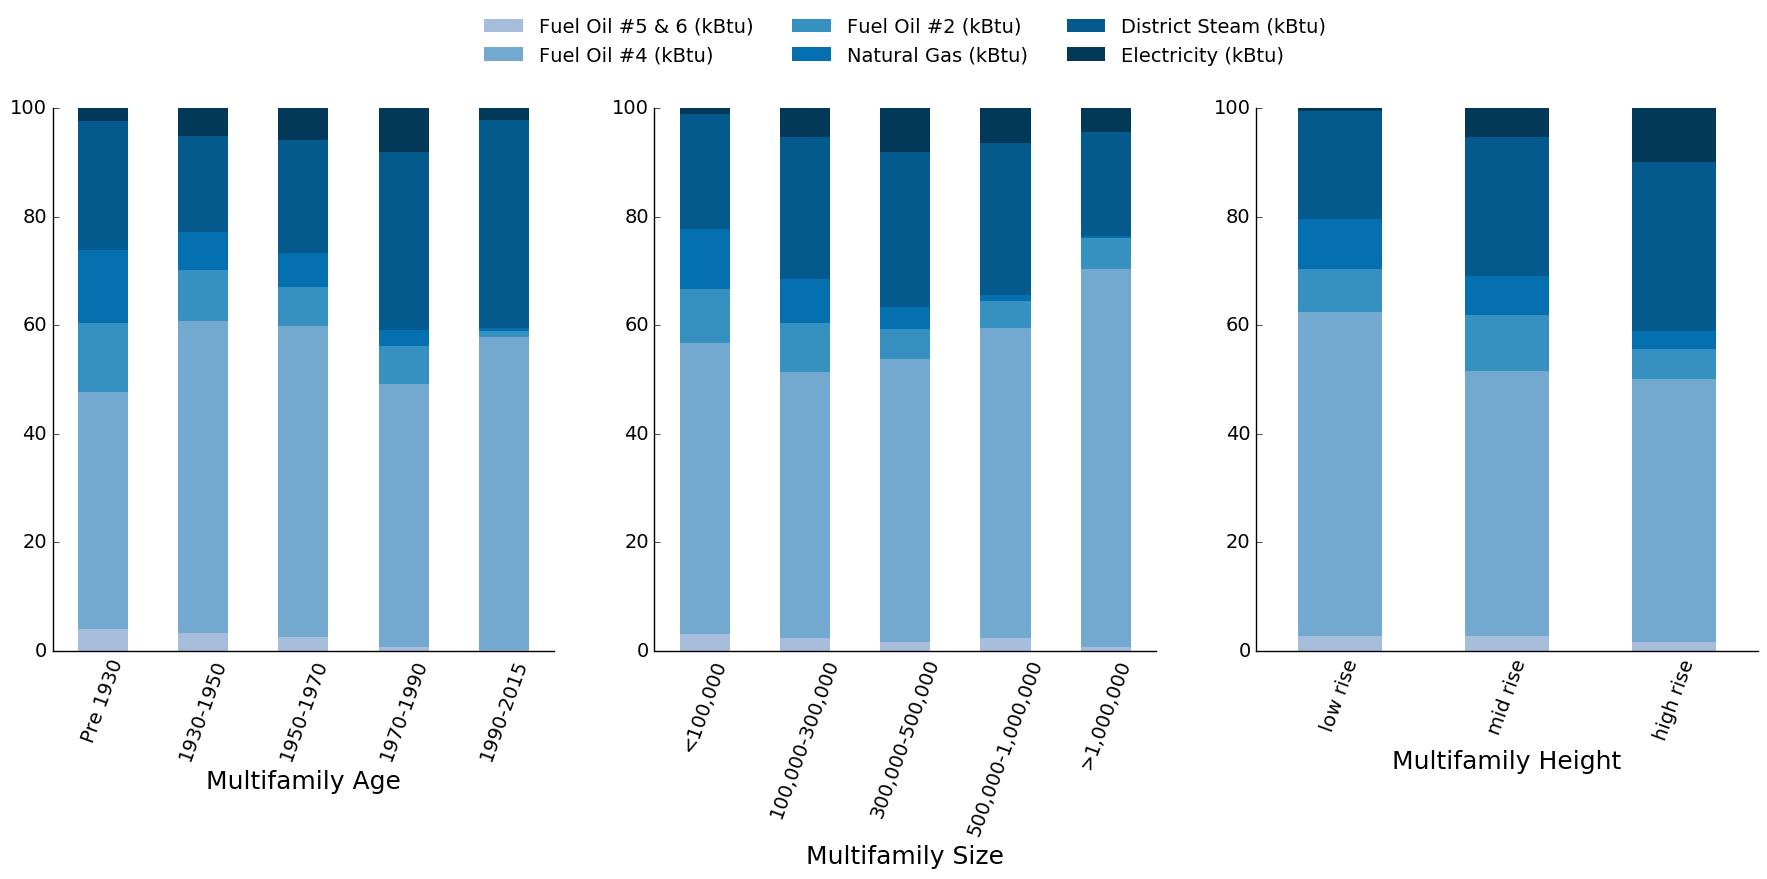

In [42]:
# Plot multifamily energy mix
fig = plt.figure(figsize=(22, 7))
sub1 = fig.add_subplot(131)
plot_agg_energy(mf, 'ageBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub1,ylim=[0,100],legend=False)
sub1.set_xlabel('Multifamily Age')
sub1.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub1.set_xticklabels(sub1.xaxis.get_majorticklabels(),rotation=70)
sub2 = fig.add_subplot(132)
plot_agg_energy(mf, 'sizeBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub2,ylim=[0,100],legend=True)
sub2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=False)
sub2.set_xlabel('Multifamily Size')
sub2.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub2.set_xticklabels(sub2.xaxis.get_majorticklabels(),rotation=70)
sub3 = fig.add_subplot(133)
plot_agg_energy(mf, 'heightBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub3,ylim=[0,100],legend=False)
sub3.set_xlabel('Multifamily Height')
sub3.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub3.set_xticklabels(sub3.xaxis.get_majorticklabels(),rotation=70)
#plt.savefig('..\Figures\energyMixMultifamily.png')
plt.show()

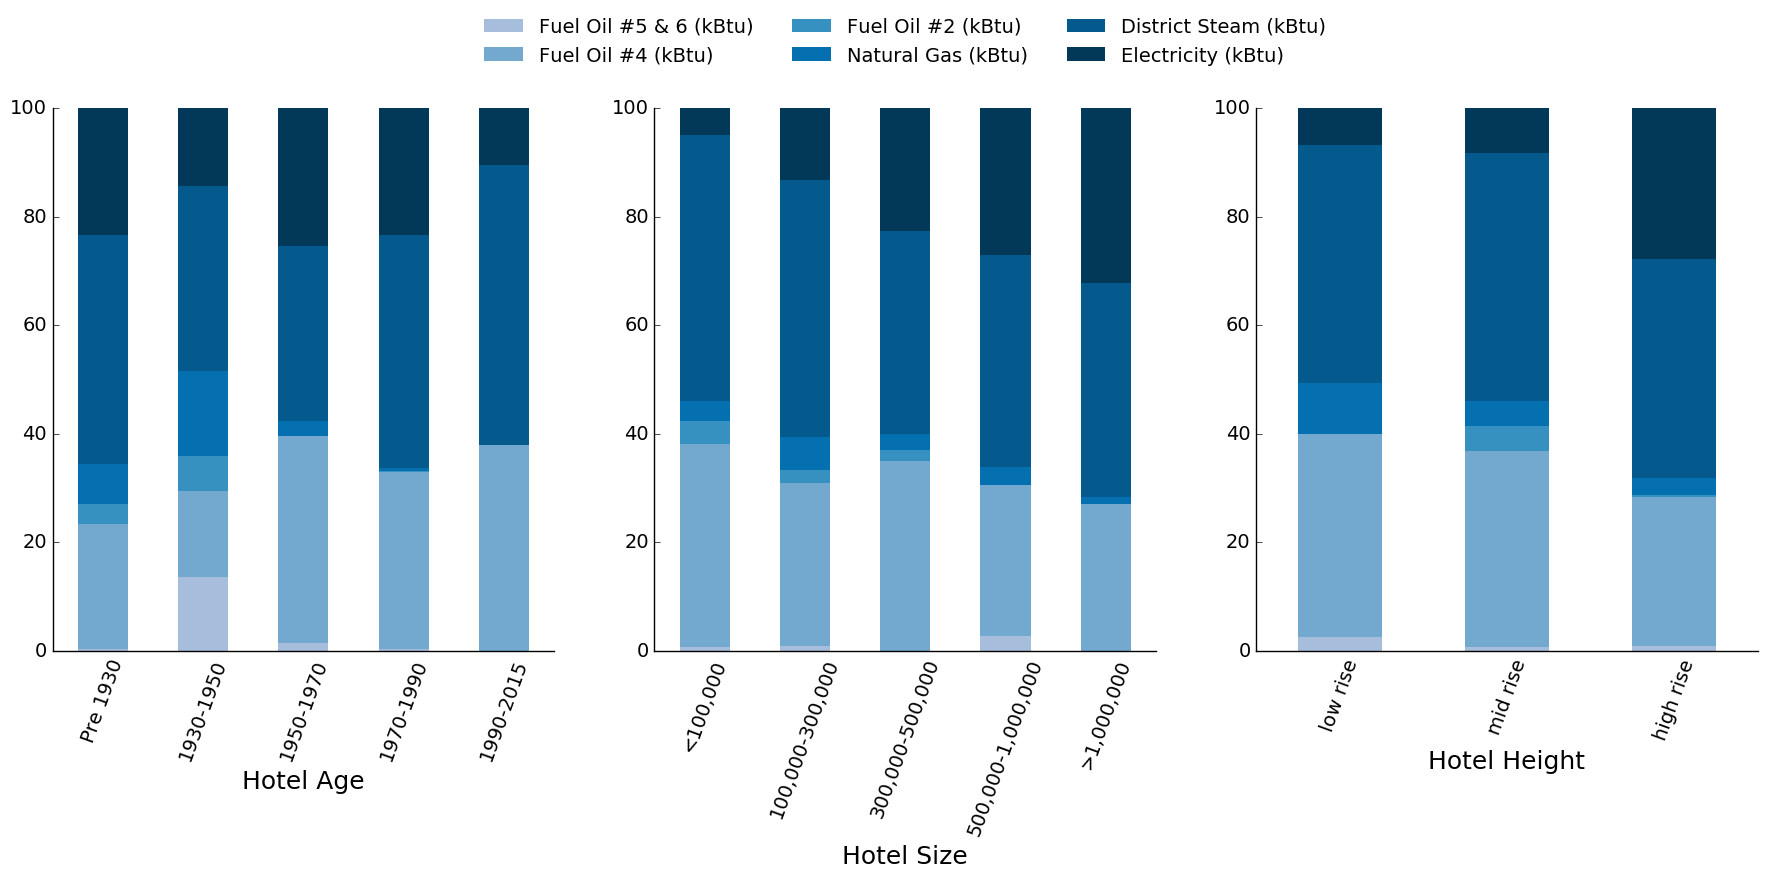

In [14]:
# Plot hotel energy mix
fig = plt.figure(figsize=(22, 7))
sub1 = fig.add_subplot(131)
plot_agg_energy(hotel, 'ageBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub1,ylim=[0,100],legend=False)
sub1.set_xlabel('Hotel Age')
sub1.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub1.set_xticklabels(sub1.xaxis.get_majorticklabels(),rotation=70)
sub2 = fig.add_subplot(132)
plot_agg_energy(hotel, 'sizeBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub2,ylim=[0,100],legend=True)
sub2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=False)
sub2.set_xlabel('Hotel Size')
sub2.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub2.set_xticklabels(sub2.xaxis.get_majorticklabels(),rotation=70)
sub3 = fig.add_subplot(133)
plot_agg_energy(hotel, 'heightBins').plot(kind='bar',stacked=True, width=0.5, color=puBu, edgecolor='none',
                                    ax=sub3,ylim=[0,100],legend=False)
sub3.set_xlabel('Hotel Height')
sub3.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
sub3.set_xticklabels(sub3.xaxis.get_majorticklabels(),rotation=70)
#plt.savefig('..\Figures\energyMixHotel.png')
plt.show()

# Statistical modeling

In [15]:
hotel = df[df['Primary Property Type - Self Selected']=='Hotel']
hotel = clean_eui(hotel)
hotel = hotel[hotel.eui<7000]

# Drop properties that didnt report significant information (Essential in this step, since sklearn does not exclude NaNs)
hotel = hotel.dropna(subset=['ageBins'])
hotel.reset_index(inplace=True)
hotel = hotel.drop('index',axis=1)

hotel = hotel[hotel['Hotel - Worker Density (Number per 1,000 ft_2)']>0]

In [16]:
def elec_prim(elec,total):
    if elec>0.5*total:
        val = 1
    else:
        val = 0
    return val

def energy_star(x):
    if x == 'No':
        val = 0
    else:
        val = 1
    return val

def renovated(x):
    if x >0:
        val = 1
    else:
        val = 0
    return val

# Feature engineering
hotel['elec_primary'] = map(elec_prim, hotel['Electricity Use - Grid Purchase (kBtu)'],
                               hotel['Site Energy Use (kBtu)'])
hotel['energyStar_elig'] = hotel['ENERGY STAR Certification - Eligibility'].map(energy_star)
hotel['is_renovated'] = hotel['YearAlter1'].map(renovated)

hotel_size = ['<100,000','100,000-200,000', '>200,000']
hotel['hotelSizeBins'] = pd.cut(df['Property GFA - Self-Reported (ft_2)'], bins=[0, 100000, 200000, 100000000],
                        labels=hotel_size)

# Transform features that show non-linear relationship to the target
hotel['log_work_dens'] = np.log(hotel['Hotel - Worker Density (Number per 1,000 ft_2)'])

features = hotel[['Occupancy', 'Hotel - Room Density (Number per 1,000 ft_2)',
                  'log_work_dens', 'Hotel - Percent That Can Be Cooled',
                  'BuiltFAR', 'elec_primary', 'energyStar_elig', 'is_renovated']]

features = pd.concat([features, pd.get_dummies(hotel['ageBins'],drop_first=True)], axis=1)
features = pd.concat([features, pd.get_dummies(hotel['heightBins'],drop_first=True)], axis=1)
features = pd.concat([features, pd.get_dummies(hotel['hotelSizeBins'],drop_first=True)], axis=1)

target = hotel.log_eui

In [17]:
features.head()

,Occupancy,"Hotel - Room Density (Number per 1,000 ft_2)",log_work_dens,Hotel - Percent That Can Be Cooled,BuiltFAR,elec_primary,energyStar_elig,is_renovated,1930-1950,1950-1970,1970-1990,1990-2015,mid rise,high rise,"100,000-200,000",">200,000"
0,100,1.65904,-0.181894,100.0,0.13,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,100,2.29760,-1.404092,90.0,0.80,0,0,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,100,1.22812,-0.752218,100.0,0.98,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,85,1.57143,-1.029627,100.0,0.02,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,100,1.59368,-1.211065,100.0,0.68,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [18]:
features.shape

(236, 16)

In [19]:
features.describe()

,Occupancy,"Hotel - Room Density (Number per 1,000 ft_2)",log_work_dens,Hotel - Percent That Can Be Cooled,BuiltFAR,elec_primary,energyStar_elig,is_renovated,1930-1950,1950-1970,1970-1990,1990-2015,mid rise,high rise,"100,000-200,000",">200,000"
count,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000,236.000000
mean,96.949153,1.759967,-0.936295,94.421483,1.468051,0.453390,0.033898,0.478814,0.055085,0.110169,0.110169,0.330508,0.508475,0.411017,0.097458,0.385593
std,8.956963,0.695883,0.555097,11.921911,3.749220,0.498881,0.181352,0.500613,0.228631,0.313766,0.313766,0.471396,0.500991,0.493064,0.297210,0.487770
min,10.000000,0.128020,-2.930319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,1.317955,-1.139716,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,1.719015,-1.002271,100.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,100.000000,2.220415,-0.637001,100.000000,0.830000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,100.000000,4.838370,0.799195,100.000000,26.910000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2, random_state=14)

In [21]:
X = sm.add_constant(X_train)
mdl = sm.OLS(y_train, X)
res = mdl.fit()
print(res.summary())

X_test_con = sm.add_constant(X_test, has_constant='add')
y_pred_lr = res.predict(X_test_con)

                            OLS Regression Results                            
Dep. Variable:                log_eui   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     4.080
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           1.38e-06
Time:                        16:41:17   Log-Likelihood:                -67.043
No. Observations:                 188   AIC:                             168.1
Df Residuals:                     171   BIC:                             223.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------

In [22]:
print "Test score (Linear regression):", r2_score(y_test, y_pred_lr)

Test score (Linear regression): 0.049017585235


In [23]:
gb = GradientBoostingRegressor(random_state=14)

parameters = {'learning_rate':[0.3, 0.4, 0.5, 0.6, 0.7], 
              'n_estimators':[1,2,3,4,5,6,7,8,9,10,15,20],
             'max_depth':[1,2,3]}

grid_cv_gb = GridSearchCV(gb, cv=10, param_grid=parameters, n_jobs=1, scoring='mean_absolute_error')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_cv_gb.fit(X_train,y_train)
    
 # Predict with the optimal model
pred = grid_cv_gb.predict(X_test)
print grid_cv_gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=2, presort='auto',
             random_state=14, subsample=1.0, verbose=0, warm_start=False)


In [24]:
gb = GradientBoostingRegressor(learning_rate=0.5, max_depth=2, n_estimators=2, random_state=14)
gb.fit(X_train, y_train)
print "Train score (Gradient boosting):", gb.score(X_train, y_train)
print "Test score (Gradient boosting):", gb.score(X_test, y_test)

Train score (Gradient boosting): 0.2881873012
Test score (Gradient boosting): 0.146881446606


In [25]:
gb.feature_importances_

array([ 0.13252556,  0.05161814,  0.54524378,  0.        ,  0.        ,
        0.        ,  0.27061252,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [26]:
# Get the errors of each model for diagnostics
errGB = y_train - gb.predict(X_train)
errLR = y_train - res.predict(X)

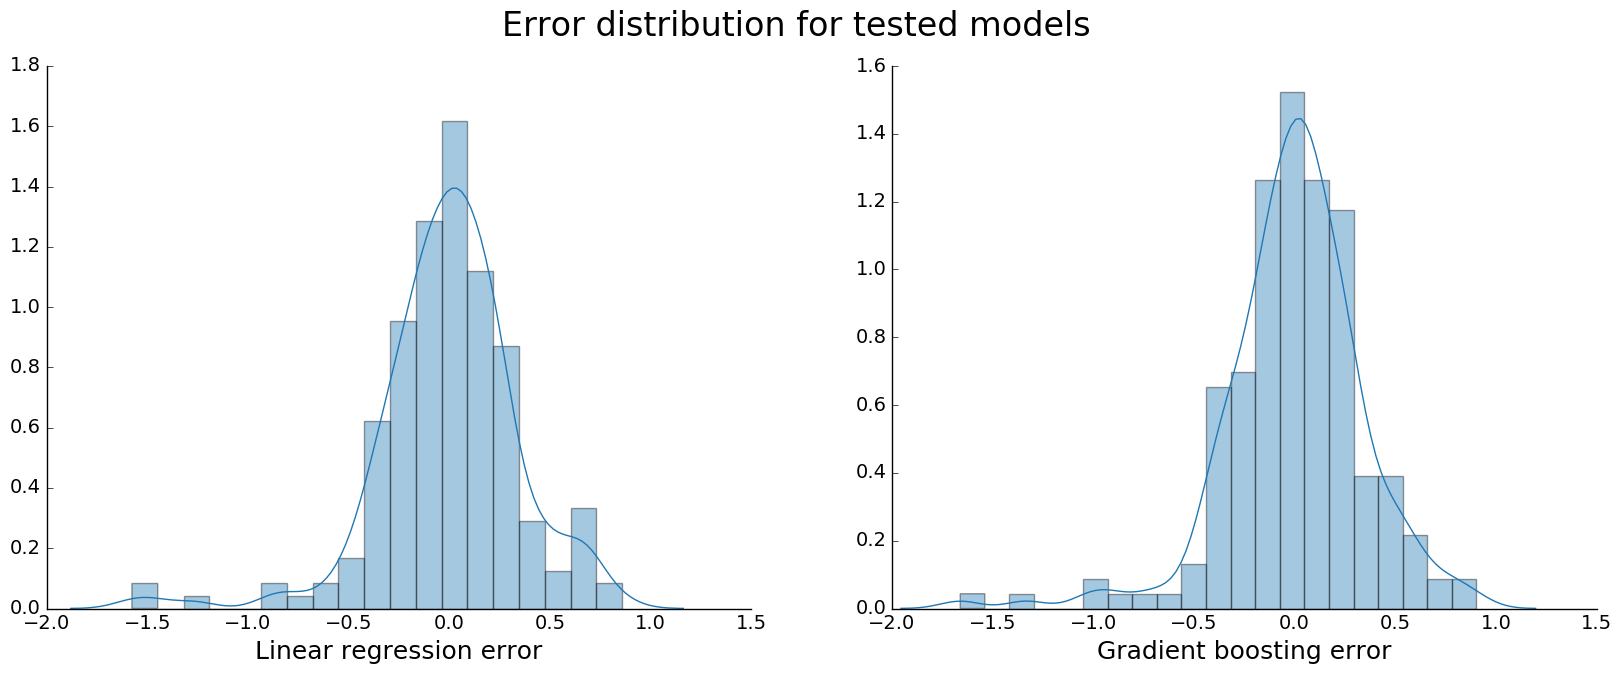

In [27]:
plt.figure(figsize=(20,7))
plt.suptitle('Error distribution for tested models', size=24)
plt.subplot(121)
snsa.distplot(errLR)
plt.xlabel('Linear regression error')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.subplot(122)
snsa.distplot(errGB)
plt.xlabel('Gradient boosting error')
plt.tick_params(axis='both',bottom='off',top='off',left='on',right='off')
plt.show()
#plt.savefig('..\Figures\errors_hists.png')

In [28]:
print 'DW test for autocorrelation (LR):',sm.stats.stattools.durbin_watson(errLR)
print 'DW test for autocorrelation (GB):',sm.stats.stattools.durbin_watson(errGB)

DW test for autocorrelation (LR): 1.96487897884
DW test for autocorrelation (GB): 2.11838792799


In [29]:
print 'Normality test (LR)', scipy.stats.normaltest(errLR)
print 'Normality test (GB)', scipy.stats.normaltest(errGB)

Normality test (LR) NormaltestResult(statistic=46.225967750277199, pvalue=9.1655523591555324e-11)
Normality test (GB) NormaltestResult(statistic=44.496674330636168, pvalue=2.176055348631911e-10)


p-value < 0.0.5 --> reject null hypothesis of normality

In [30]:
# Get model output and difference from reported EUI
hotel['pred_eui_gb'] = gb.predict(features)
hotel['diff_eui_pred'] = gb.predict(features) - hotel.log_eui

In [31]:
# Binning based on quartiles
hotel['model_score'] = pd.cut(hotel['diff_eui_pred'], 
                              bins=hotel['diff_eui_pred'].describe()[3::].values,
                              labels=['D','C','B','A'])

In [32]:
# Transform coordinates to lat/lon
hotel.XCoord = pd.to_numeric(hotel.XCoord, errors=coerce)
hotel.YCoord = pd.to_numeric(hotel.YCoord, errors=coerce)

lat=[]
lon=[]
NYSP1983 = pyproj.Proj(init="ESRI:102718", preserve_units=True)
for i in hotel.index:
    x, y = (hotel.XCoord[i], hotel.YCoord[i])
    lat.append(NYSP1983(x, y, inverse=True)[1])
    lon.append(NYSP1983(x, y, inverse=True)[0])

hotel['lat'] = lat
hotel['lon'] = lon

In [33]:
# Making sure that all properties have a score
hotel = hotel[(hotel.model_score =='A')|(hotel.model_score =='B')|(hotel.model_score =='C')
              |(hotel.model_score =='D')]

In [34]:
# Save file
hotel.to_csv('..\Output\hotel_output.csv')